## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import squidpy as sq

In [2]:
import models
import metrics
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#sc.set_figure_params(scanpy=True, fontsize=16)


In [3]:
adata = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 73642 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts'
    uns: 'Cell_class_colors', 'log1p'
    obsm: 'spatial', 'spatial3d'

In [4]:
adata.obs['Cell_class'].value_counts()

Inhibitory       24761
Excitatory       11757
Ambiguous         9269
Astrocyte         8393
OD Mature 2       5736
Endothelial 1     3799
OD Immature 1     2457
Ependymal         1961
Microglia         1472
Endothelial 3     1369
OD Mature 1        952
Pericytes          638
Endothelial 2      581
OD Mature 4        367
OD Immature 2       91
OD Mature 3         39
Name: Cell_class, dtype: int64

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


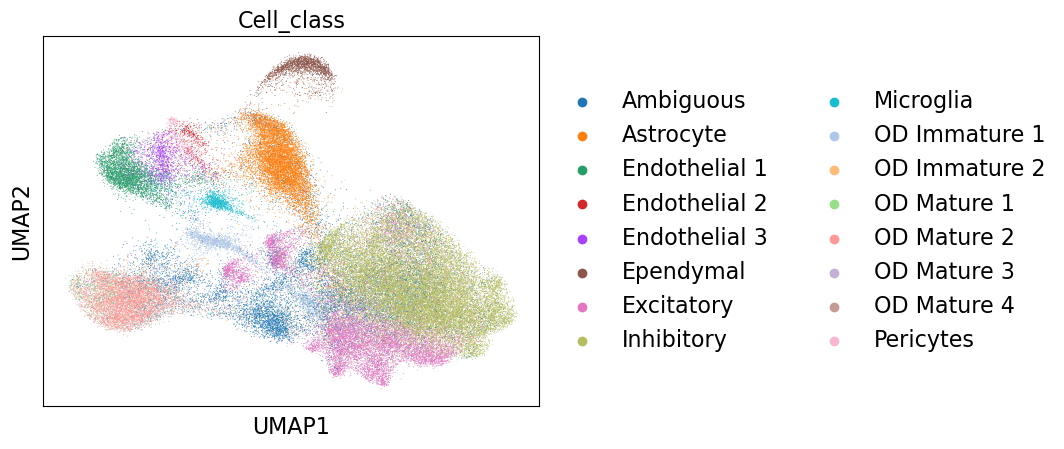

In [5]:
import squidpy as sq
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='Cell_class')

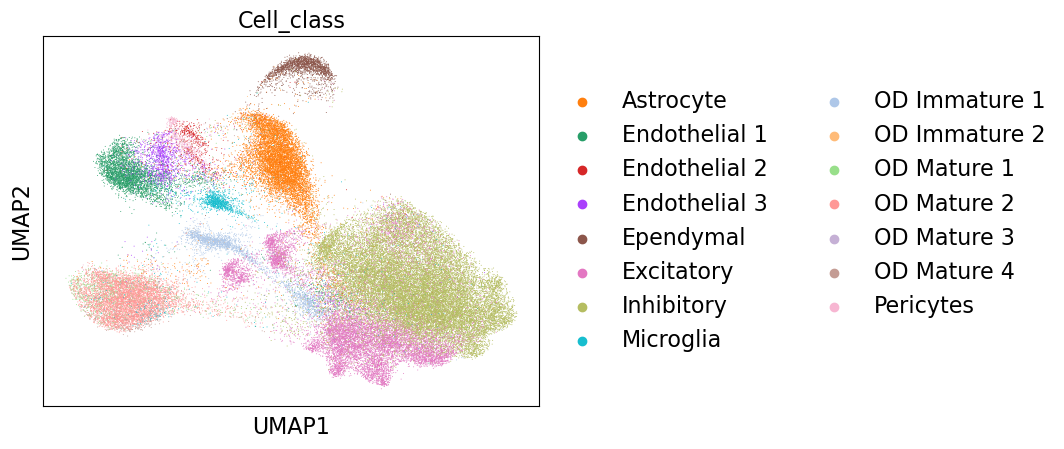

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


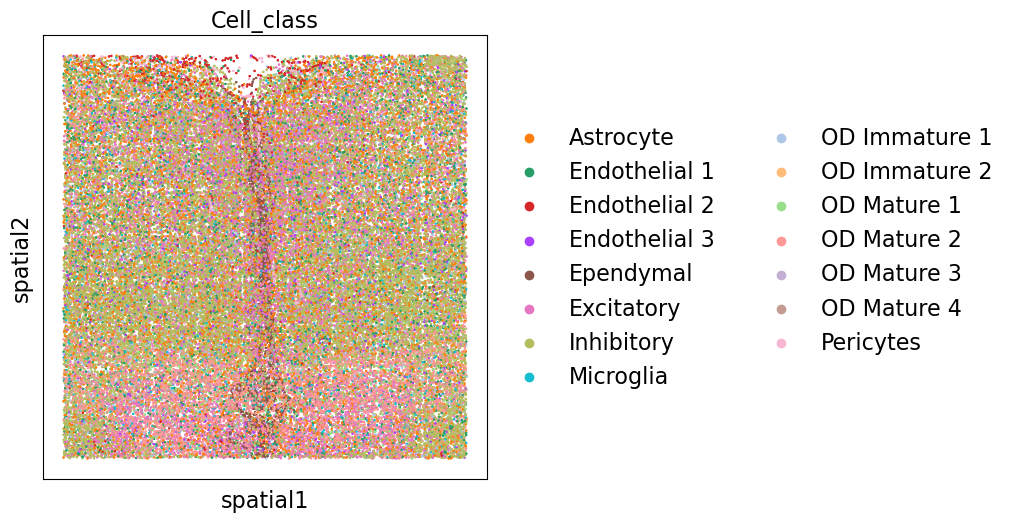

In [6]:
adata= adata[adata.obs['Cell_class'].isin(['OD Mature 2',
 'OD Immature 1',
 'Inhibitory',
 'Excitatory',
 'Microglia',
 'Astrocyte',
 'Endothelial 2',
 'Endothelial 3',
 'Endothelial 1',
 'OD Mature 1',
 'OD Mature 4',
 'Pericytes',
 'OD Mature 3',
 'Ependymal',
 'OD Immature 2']
)]
sc.pl.umap(adata,color='Cell_class')
sq.pl.spatial_scatter(
    adata, color="Cell_class", shape=None, figsize=(10, 10)
)

In [7]:
import numpy as np

# Define a dictionary to map each cluster to its corresponding cell type
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}

# Create an empty list to store the updated cell types
cell_type_list = []

# Iterate over each cluster and assign the corresponding cell type
for i in range(adata.n_obs):
    cluster_name = adata.obs['Cell_class'][i]
    if cluster_name in cell_type_mapping:
        cell_type_list.append(cell_type_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['CellType'] = np.array(cell_type_list)


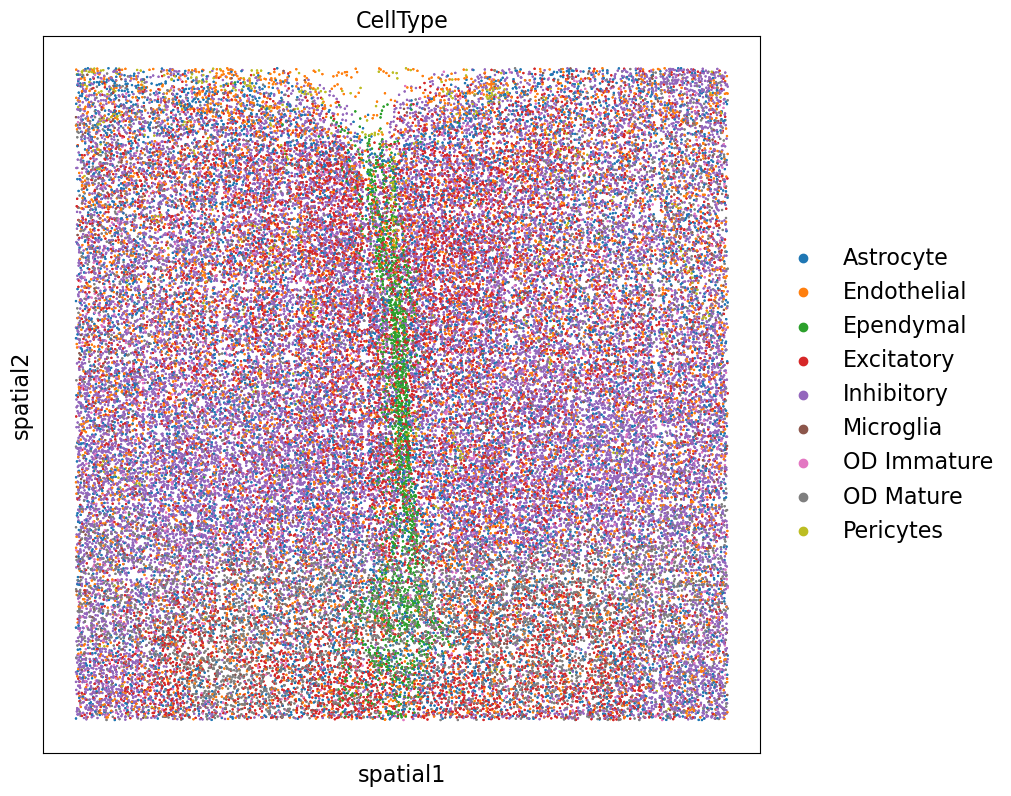

In [8]:
sq.pl.spatial_scatter(
    adata, color="CellType", shape=None, figsize=(10, 10)
)


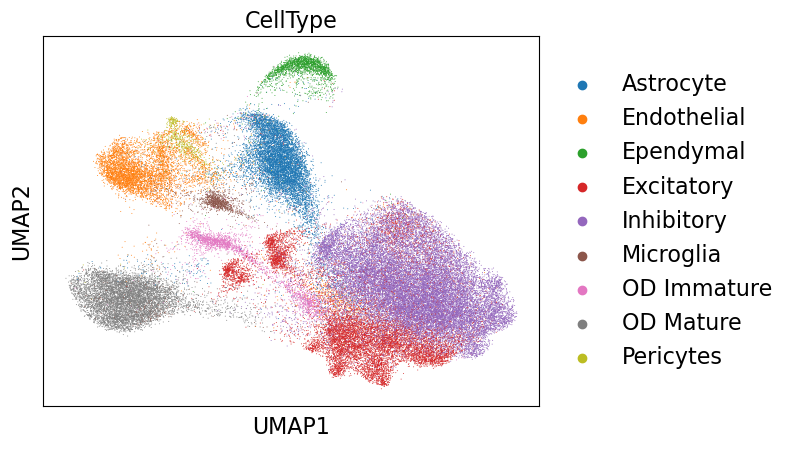

In [9]:
sc.pl.umap(adata,color='CellType')

In [10]:
len(set(adata.obs['CellType']))

9

In [11]:
adata.obsm['spatial']

array([[0.00906344, 0.08041869],
       [0.03281294, 0.09883481],
       [0.04015782, 0.07502649],
       ...,
       [0.93928628, 0.88763104],
       [0.97045268, 0.88984304],
       [0.99918989, 0.94175804]])

In [12]:
epoch_num=20
prob_list = models.follow_training_dyn_neural_net(adata, label_key='CellType',iterNum=epoch_num, device=device, batch_size=64)
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
adata.obs["var"] = all_var.detach().numpy()
adata.obs["conf"] = all_conf.detach().numpy()



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.203
[1,    22] loss: 2.165
[1,    32] loss: 2.109
[1,    42] loss: 2.070
[1,    52] loss: 2.030
[1,    62] loss: 1.982
[1,    72] loss: 1.921
[1,    82] loss: 1.849
[1,    92] loss: 1.774
[1,   102] loss: 1.722
[1,   112] loss: 1.636
[1,   122] loss: 1.554
[1,   132] loss: 1.452
[1,   142] loss: 1.367
[1,   152] loss: 1.263
[1,   162] loss: 1.214
[1,   172] loss: 1.144
[1,   182] loss: 1.010
[1,   192] loss: 0.934
[1,   202] loss: 0.875
[1,   212] loss: 0.824
[1,   222] loss: 0.765
[1,   232] loss: 0.727
[1,   242] loss: 0.645
[1,   252] loss: 0.607
[1,   262] loss: 0.564
[1,   272] loss: 0.591
[1,   282] loss: 0.540
[1,   292] loss: 0.558
[1,   302] loss: 0.488
[1,   312] loss: 0.488
[1,   322] loss: 0.444
[1,   332] loss: 0.453
[1,   342] loss: 0.463
[1,   352] loss: 0.416
[1,   362] loss: 0.407
[1,   372] loss: 0.448
[1,   382] loss: 0.394
[1,   392] loss: 0.407
[1,   402] loss: 0.369
[1,   412] loss: 0.360
[1,   422] loss: 0.375
[1,   432] 

[4,   582] loss: 0.205
[4,   592] loss: 0.162
[4,   602] loss: 0.193
[4,   612] loss: 0.195
[4,   622] loss: 0.148
[4,   632] loss: 0.187
[4,   642] loss: 0.187
[4,   652] loss: 0.190
[4,   662] loss: 0.208
[4,   672] loss: 0.217
[4,   682] loss: 0.166
[4,   692] loss: 0.133
[4,   702] loss: 0.167
[4,   712] loss: 0.166
[4,   722] loss: 0.173
[4,   732] loss: 0.171
[4,   742] loss: 0.169
[4,   752] loss: 0.219
[4,   762] loss: 0.185
[4,   772] loss: 0.204
[4,   782] loss: 0.202
[4,   792] loss: 0.164
[4,   802] loss: 0.142
[4,   812] loss: 0.160
[4,   822] loss: 0.190
[4,   832] loss: 0.174
[4,   842] loss: 0.193
[4,   852] loss: 0.179
[4,   862] loss: 0.169
[4,   872] loss: 0.139
[4,   882] loss: 0.202
[4,   892] loss: 0.188
[4,   902] loss: 0.185
[4,   912] loss: 0.189
[4,   922] loss: 0.157
[4,   932] loss: 0.186
[4,   942] loss: 0.165
[4,   952] loss: 0.169
[4,   962] loss: 0.133
[4,   972] loss: 0.158
[4,   982] loss: 0.186
[4,   992] loss: 0.212
[4,  1002] loss: 0.148
[5,     2] 

[8,   172] loss: 0.176
[8,   182] loss: 0.180
[8,   192] loss: 0.221
[8,   202] loss: 0.128
[8,   212] loss: 0.133
[8,   222] loss: 0.151
[8,   232] loss: 0.150
[8,   242] loss: 0.176
[8,   252] loss: 0.144
[8,   262] loss: 0.169
[8,   272] loss: 0.169
[8,   282] loss: 0.145
[8,   292] loss: 0.170
[8,   302] loss: 0.191
[8,   312] loss: 0.134
[8,   322] loss: 0.180
[8,   332] loss: 0.161
[8,   342] loss: 0.139
[8,   352] loss: 0.177
[8,   362] loss: 0.165
[8,   372] loss: 0.140
[8,   382] loss: 0.156
[8,   392] loss: 0.187
[8,   402] loss: 0.229
[8,   412] loss: 0.217
[8,   422] loss: 0.120
[8,   432] loss: 0.198
[8,   442] loss: 0.157
[8,   452] loss: 0.156
[8,   462] loss: 0.156
[8,   472] loss: 0.177
[8,   482] loss: 0.178
[8,   492] loss: 0.149
[8,   502] loss: 0.221
[8,   512] loss: 0.168
[8,   522] loss: 0.161
[8,   532] loss: 0.144
[8,   542] loss: 0.148
[8,   552] loss: 0.128
[8,   562] loss: 0.194
[8,   572] loss: 0.184
[8,   582] loss: 0.226
[8,   592] loss: 0.154
[8,   602] 

[11,   722] loss: 0.156
[11,   732] loss: 0.165
[11,   742] loss: 0.153
[11,   752] loss: 0.191
[11,   762] loss: 0.141
[11,   772] loss: 0.177
[11,   782] loss: 0.163
[11,   792] loss: 0.187
[11,   802] loss: 0.136
[11,   812] loss: 0.162
[11,   822] loss: 0.090
[11,   832] loss: 0.168
[11,   842] loss: 0.150
[11,   852] loss: 0.145
[11,   862] loss: 0.144
[11,   872] loss: 0.138
[11,   882] loss: 0.121
[11,   892] loss: 0.202
[11,   902] loss: 0.146
[11,   912] loss: 0.140
[11,   922] loss: 0.152
[11,   932] loss: 0.223
[11,   942] loss: 0.113
[11,   952] loss: 0.136
[11,   962] loss: 0.152
[11,   972] loss: 0.163
[11,   982] loss: 0.176
[11,   992] loss: 0.202
[11,  1002] loss: 0.151
[12,     2] loss: 0.024
[12,    12] loss: 0.145
[12,    22] loss: 0.156
[12,    32] loss: 0.145
[12,    42] loss: 0.141
[12,    52] loss: 0.184
[12,    62] loss: 0.115
[12,    72] loss: 0.146
[12,    82] loss: 0.162
[12,    92] loss: 0.139
[12,   102] loss: 0.135
[12,   112] loss: 0.135
[12,   122] loss

[15,   192] loss: 0.135
[15,   202] loss: 0.112
[15,   212] loss: 0.107
[15,   222] loss: 0.169
[15,   232] loss: 0.132
[15,   242] loss: 0.134
[15,   252] loss: 0.140
[15,   262] loss: 0.149
[15,   272] loss: 0.121
[15,   282] loss: 0.146
[15,   292] loss: 0.152
[15,   302] loss: 0.168
[15,   312] loss: 0.138
[15,   322] loss: 0.143
[15,   332] loss: 0.125
[15,   342] loss: 0.165
[15,   352] loss: 0.168
[15,   362] loss: 0.152
[15,   372] loss: 0.140
[15,   382] loss: 0.179
[15,   392] loss: 0.125
[15,   402] loss: 0.143
[15,   412] loss: 0.132
[15,   422] loss: 0.091
[15,   432] loss: 0.125
[15,   442] loss: 0.148
[15,   452] loss: 0.098
[15,   462] loss: 0.117
[15,   472] loss: 0.156
[15,   482] loss: 0.124
[15,   492] loss: 0.127
[15,   502] loss: 0.148
[15,   512] loss: 0.118
[15,   522] loss: 0.138
[15,   532] loss: 0.123
[15,   542] loss: 0.132
[15,   552] loss: 0.174
[15,   562] loss: 0.165
[15,   572] loss: 0.140
[15,   582] loss: 0.128
[15,   592] loss: 0.158
[15,   602] loss

[18,   672] loss: 0.135
[18,   682] loss: 0.113
[18,   692] loss: 0.149
[18,   702] loss: 0.174
[18,   712] loss: 0.179
[18,   722] loss: 0.141
[18,   732] loss: 0.144
[18,   742] loss: 0.136
[18,   752] loss: 0.122
[18,   762] loss: 0.141
[18,   772] loss: 0.116
[18,   782] loss: 0.136
[18,   792] loss: 0.102
[18,   802] loss: 0.132
[18,   812] loss: 0.109
[18,   822] loss: 0.131
[18,   832] loss: 0.118
[18,   842] loss: 0.154
[18,   852] loss: 0.145
[18,   862] loss: 0.120
[18,   872] loss: 0.111
[18,   882] loss: 0.105
[18,   892] loss: 0.167
[18,   902] loss: 0.175
[18,   912] loss: 0.142
[18,   922] loss: 0.128
[18,   932] loss: 0.135
[18,   942] loss: 0.113
[18,   952] loss: 0.145
[18,   962] loss: 0.133
[18,   972] loss: 0.159
[18,   982] loss: 0.146
[18,   992] loss: 0.118
[18,  1002] loss: 0.158
[19,     2] loss: 0.047
[19,    12] loss: 0.141
[19,    22] loss: 0.132
[19,    32] loss: 0.142
[19,    42] loss: 0.176
[19,    52] loss: 0.112
[19,    62] loss: 0.144
[19,    72] loss

In [13]:
cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'CellType',device,probability=0.05,percentile=90,epoch_num=epoch_num)
cutoff_conf , cutoff_var

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.214
[1,    22] loss: 2.199
[1,    32] loss: 2.155
[1,    42] loss: 2.131
[1,    52] loss: 2.090
[1,    62] loss: 2.057
[1,    72] loss: 1.998
[1,    82] loss: 1.943
[1,    92] loss: 1.893
[1,   102] loss: 1.842
[1,   112] loss: 1.753
[1,   122] loss: 1.702
[1,   132] loss: 1.616
[1,   142] loss: 1.520
[1,   152] loss: 1.465
[1,   162] loss: 1.357
[1,   172] loss: 1.342
[1,   182] loss: 1.232
[1,   192] loss: 1.202
[1,   202] loss: 1.103
[1,   212] loss: 1.071
[1,   222] loss: 0.969
[1,   232] loss: 1.016
[1,   242] loss: 0.981
[1,   252] loss: 0.906
[1,   262] loss: 0.882
[1,   272] loss: 0.841
[1,   282] loss: 0.806
[1,   292] loss: 0.822
[1,   302] loss: 0.854
[1,   312] loss: 0.784
[1,   322] loss: 0.718
[1,   332] loss: 0.651
[1,   342] loss: 0.728
[1,   352] loss: 0.684
[1,   362] loss: 0.666
[1,   372] loss: 0.718
[1,   382] loss: 0.695
[1,   392] loss: 0.730
[1,   402] loss: 0.639
[1,   412] loss: 0.815
[1,   422] loss: 0.680
[1,   432] 

[4,   582] loss: 0.482
[4,   592] loss: 0.503
[4,   602] loss: 0.486
[4,   612] loss: 0.428
[4,   622] loss: 0.500
[4,   632] loss: 0.506
[4,   642] loss: 0.461
[4,   652] loss: 0.485
[4,   662] loss: 0.567
[4,   672] loss: 0.428
[4,   682] loss: 0.434
[4,   692] loss: 0.458
[4,   702] loss: 0.474
[4,   712] loss: 0.395
[4,   722] loss: 0.418
[4,   732] loss: 0.492
[4,   742] loss: 0.587
[4,   752] loss: 0.469
[4,   762] loss: 0.444
[4,   772] loss: 0.489
[4,   782] loss: 0.521
[4,   792] loss: 0.458
[4,   802] loss: 0.434
[4,   812] loss: 0.444
[4,   822] loss: 0.429
[4,   832] loss: 0.604
[4,   842] loss: 0.476
[4,   852] loss: 0.444
[4,   862] loss: 0.498
[4,   872] loss: 0.506
[4,   882] loss: 0.434
[4,   892] loss: 0.453
[4,   902] loss: 0.447
[4,   912] loss: 0.472
[4,   922] loss: 0.391
[4,   932] loss: 0.548
[4,   942] loss: 0.478
[4,   952] loss: 0.537
[4,   962] loss: 0.434
[4,   972] loss: 0.379
[4,   982] loss: 0.558
[4,   992] loss: 0.559
[4,  1002] loss: 0.490
[5,     2] 

[8,   162] loss: 0.500
[8,   172] loss: 0.434
[8,   182] loss: 0.471
[8,   192] loss: 0.455
[8,   202] loss: 0.450
[8,   212] loss: 0.411
[8,   222] loss: 0.407
[8,   232] loss: 0.387
[8,   242] loss: 0.482
[8,   252] loss: 0.463
[8,   262] loss: 0.513
[8,   272] loss: 0.488
[8,   282] loss: 0.471
[8,   292] loss: 0.485
[8,   302] loss: 0.532
[8,   312] loss: 0.412
[8,   322] loss: 0.445
[8,   332] loss: 0.365
[8,   342] loss: 0.381
[8,   352] loss: 0.515
[8,   362] loss: 0.476
[8,   372] loss: 0.448
[8,   382] loss: 0.475
[8,   392] loss: 0.503
[8,   402] loss: 0.453
[8,   412] loss: 0.487
[8,   422] loss: 0.446
[8,   432] loss: 0.500
[8,   442] loss: 0.468
[8,   452] loss: 0.439
[8,   462] loss: 0.461
[8,   472] loss: 0.490
[8,   482] loss: 0.496
[8,   492] loss: 0.465
[8,   502] loss: 0.405
[8,   512] loss: 0.501
[8,   522] loss: 0.454
[8,   532] loss: 0.457
[8,   542] loss: 0.441
[8,   552] loss: 0.500
[8,   562] loss: 0.476
[8,   572] loss: 0.417
[8,   582] loss: 0.452
[8,   592] 

[11,   762] loss: 0.403
[11,   772] loss: 0.407
[11,   782] loss: 0.396
[11,   792] loss: 0.359
[11,   802] loss: 0.430
[11,   812] loss: 0.464
[11,   822] loss: 0.423
[11,   832] loss: 0.400
[11,   842] loss: 0.448
[11,   852] loss: 0.417
[11,   862] loss: 0.383
[11,   872] loss: 0.436
[11,   882] loss: 0.438
[11,   892] loss: 0.517
[11,   902] loss: 0.472
[11,   912] loss: 0.499
[11,   922] loss: 0.449
[11,   932] loss: 0.508
[11,   942] loss: 0.404
[11,   952] loss: 0.503
[11,   962] loss: 0.435
[11,   972] loss: 0.445
[11,   982] loss: 0.380
[11,   992] loss: 0.465
[11,  1002] loss: 0.451
[12,     2] loss: 0.085
[12,    12] loss: 0.412
[12,    22] loss: 0.482
[12,    32] loss: 0.416
[12,    42] loss: 0.467
[12,    52] loss: 0.376
[12,    62] loss: 0.440
[12,    72] loss: 0.513
[12,    82] loss: 0.420
[12,    92] loss: 0.461
[12,   102] loss: 0.414
[12,   112] loss: 0.485
[12,   122] loss: 0.446
[12,   132] loss: 0.390
[12,   142] loss: 0.469
[12,   152] loss: 0.447
[12,   162] loss

[15,   172] loss: 0.455
[15,   182] loss: 0.524
[15,   192] loss: 0.449
[15,   202] loss: 0.342
[15,   212] loss: 0.404
[15,   222] loss: 0.355
[15,   232] loss: 0.384
[15,   242] loss: 0.435
[15,   252] loss: 0.402
[15,   262] loss: 0.345
[15,   272] loss: 0.519
[15,   282] loss: 0.454
[15,   292] loss: 0.475
[15,   302] loss: 0.440
[15,   312] loss: 0.500
[15,   322] loss: 0.399
[15,   332] loss: 0.444
[15,   342] loss: 0.459
[15,   352] loss: 0.421
[15,   362] loss: 0.398
[15,   372] loss: 0.376
[15,   382] loss: 0.430
[15,   392] loss: 0.378
[15,   402] loss: 0.332
[15,   412] loss: 0.392
[15,   422] loss: 0.425
[15,   432] loss: 0.426
[15,   442] loss: 0.427
[15,   452] loss: 0.426
[15,   462] loss: 0.430
[15,   472] loss: 0.395
[15,   482] loss: 0.446
[15,   492] loss: 0.420
[15,   502] loss: 0.312
[15,   512] loss: 0.472
[15,   522] loss: 0.372
[15,   532] loss: 0.391
[15,   542] loss: 0.480
[15,   552] loss: 0.484
[15,   562] loss: 0.437
[15,   572] loss: 0.427
[15,   582] loss

[18,   582] loss: 0.386
[18,   592] loss: 0.411
[18,   602] loss: 0.425
[18,   612] loss: 0.358
[18,   622] loss: 0.439
[18,   632] loss: 0.324
[18,   642] loss: 0.488
[18,   652] loss: 0.415
[18,   662] loss: 0.475
[18,   672] loss: 0.399
[18,   682] loss: 0.434
[18,   692] loss: 0.358
[18,   702] loss: 0.402
[18,   712] loss: 0.389
[18,   722] loss: 0.307
[18,   732] loss: 0.388
[18,   742] loss: 0.540
[18,   752] loss: 0.502
[18,   762] loss: 0.429
[18,   772] loss: 0.446
[18,   782] loss: 0.446
[18,   792] loss: 0.436
[18,   802] loss: 0.409
[18,   812] loss: 0.357
[18,   822] loss: 0.390
[18,   832] loss: 0.350
[18,   842] loss: 0.384
[18,   852] loss: 0.374
[18,   862] loss: 0.320
[18,   872] loss: 0.436
[18,   882] loss: 0.491
[18,   892] loss: 0.444
[18,   902] loss: 0.381
[18,   912] loss: 0.388
[18,   922] loss: 0.353
[18,   932] loss: 0.348
[18,   942] loss: 0.430
[18,   952] loss: 0.347
[18,   962] loss: 0.387
[18,   972] loss: 0.324
[18,   982] loss: 0.380
[18,   992] loss

(0.06705646216869354, 0.03617711365222931)

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


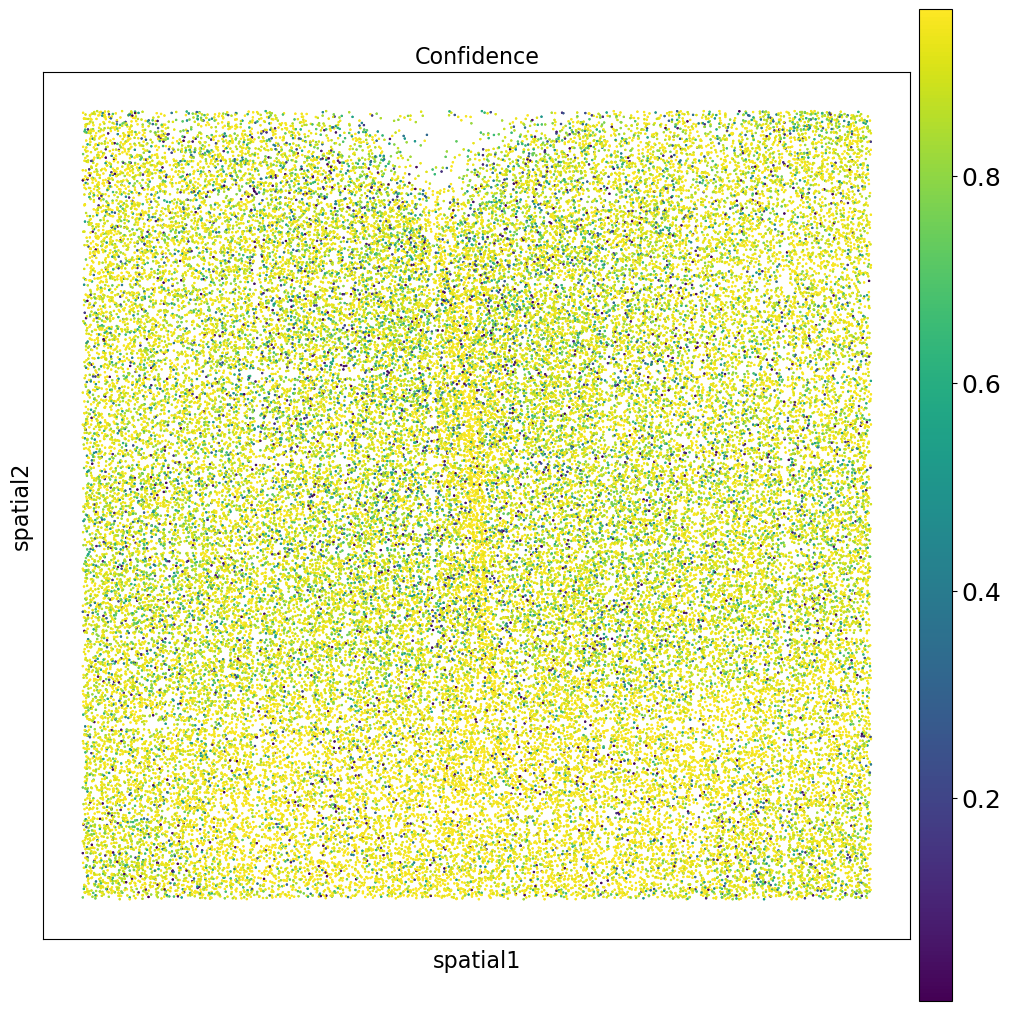

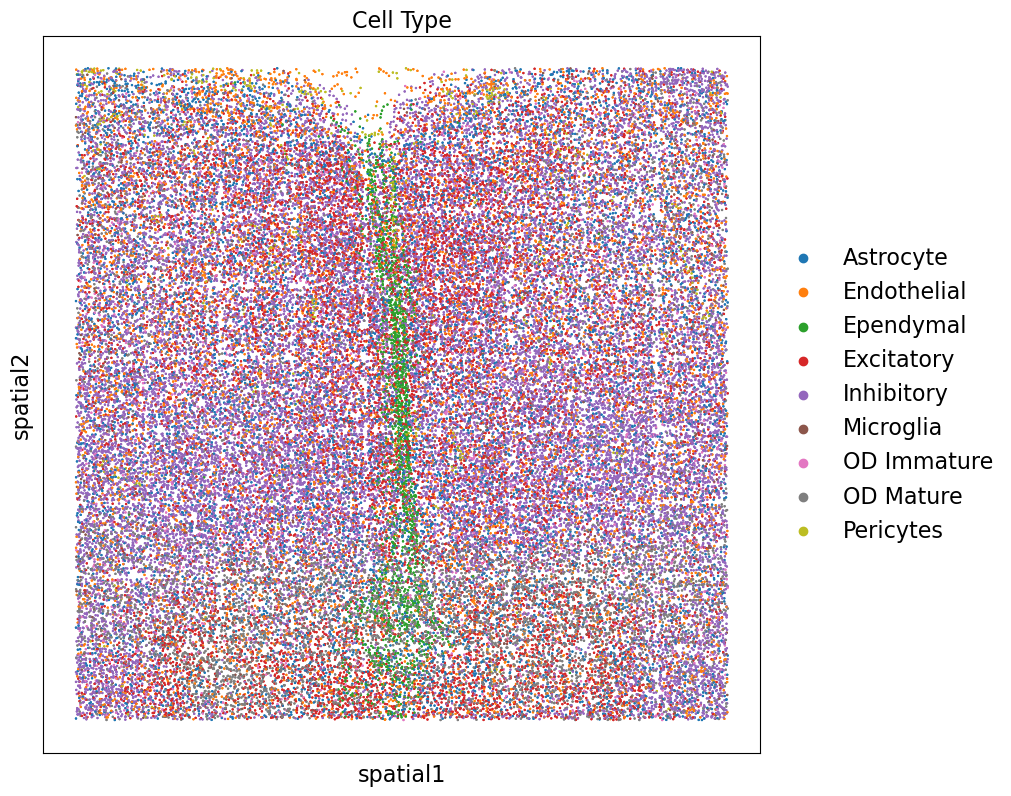

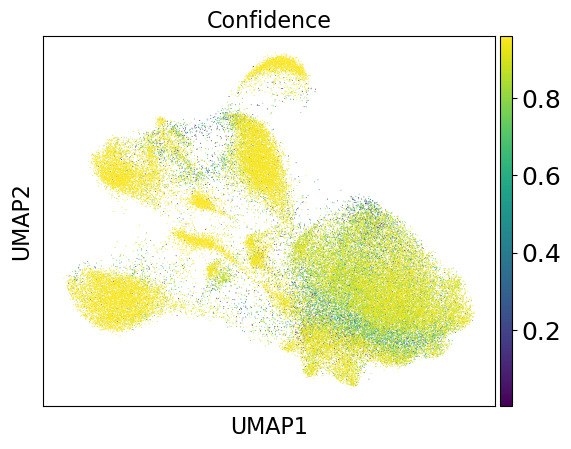

In [14]:
sq.pl.spatial_scatter(
    adata, color=['conf'], shape=None, figsize=(10, 10), title='Confidence',
)
sq.pl.spatial_scatter(
    adata, color=["CellType"], shape=None, figsize=(10, 10),   title='Cell Type',
)
sc.pl.umap(adata,color=['conf'], title='Confidence')

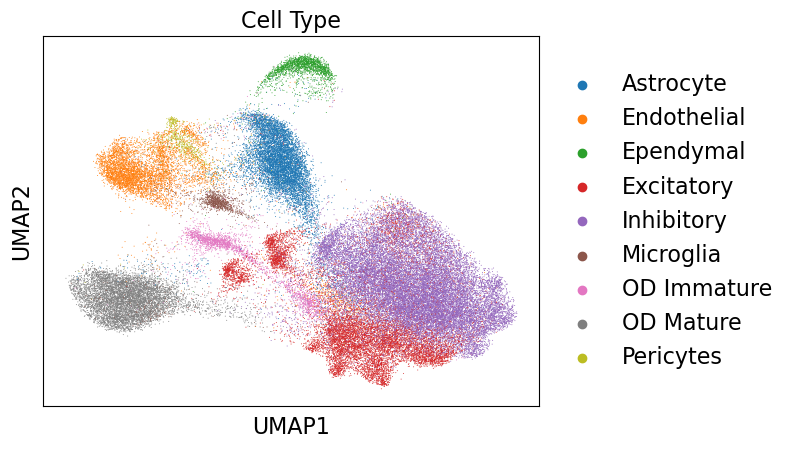

In [15]:
sc.pl.umap(adata,color=["CellType"],   title='Cell Type')


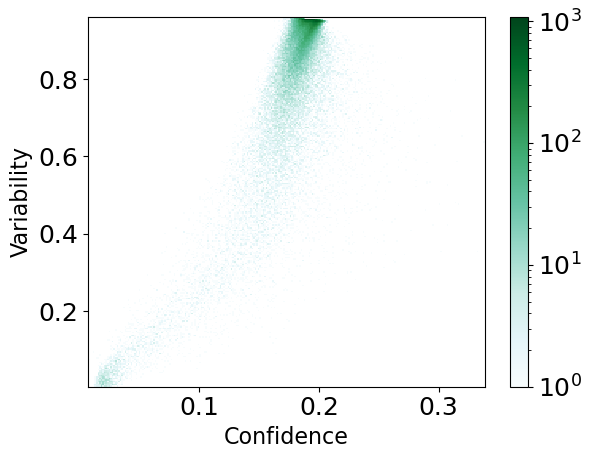

In [16]:
import matplotlib
plt.xlim([0,1])
plt.ylim([0,1])
plt.hist2d(adata.obs['var'], adata.obs['conf'], bins=250, cmap='BuGn',norm=matplotlib.colors.LogNorm())
plt.xlabel('Confidence')
plt.ylabel('Variability')
plt.colorbar()

In [17]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

adata.obs['conf_binaries'].value_counts()

True     63467
False      906
Name: conf_binaries, dtype: int64

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


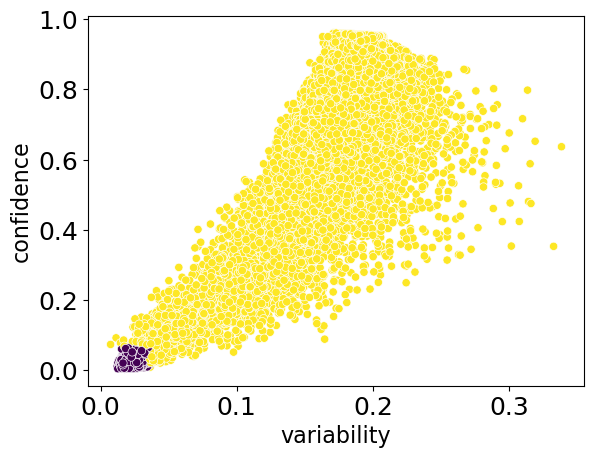

In [18]:
sns.scatterplot( all_var.detach().numpy(),all_conf.detach().numpy(),c=adata.obs['conf_binaries'].astype(int))
plt.xlabel('variability')
plt.ylabel('confidence')
plt.show()


In [19]:

marker_genes_dict = {'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Pericytes':['Myh11'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Microglia':['Selplg'],
                     'Astrocytes': ['Aqp4'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp']}


marker_genes_list = ['Gad1','Slc17a6',
                     'Myh11',
                     'Fn1',
                     'Cd24a',
                     'Selplg',
                     'Aqp4',
                     'Pdgfra',
                     'Ttyh2','Mbp']



In [20]:
bdata = adata.copy()
sc.pp.scale(bdata)


OD Mature


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


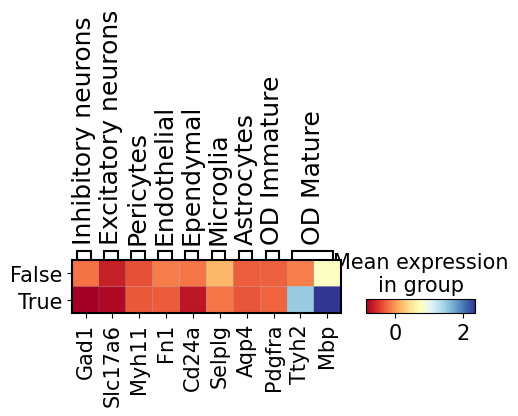

True     7067
False      27
Name: conf_binaries, dtype: int64
OD Immature


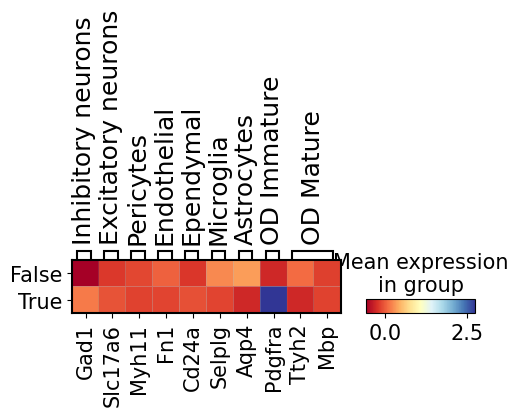

True     2505
False      43
Name: conf_binaries, dtype: int64
Inhibitory


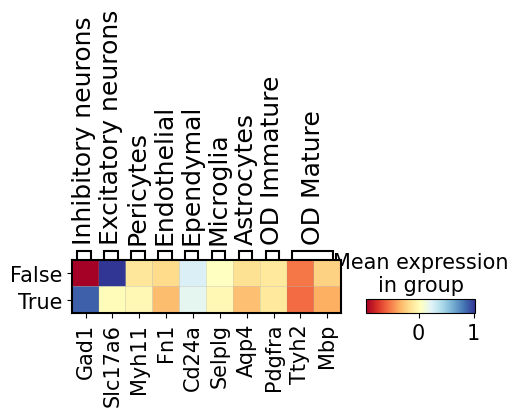

True     24232
False      529
Name: conf_binaries, dtype: int64
Excitatory


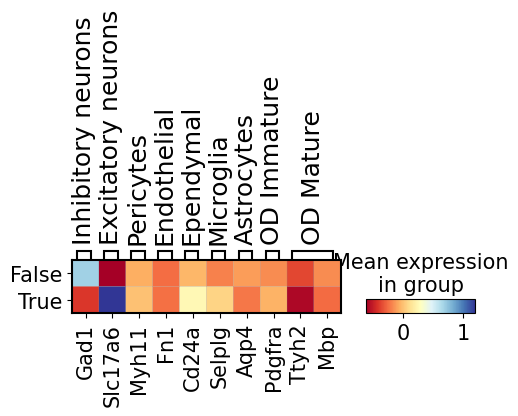

True     11560
False      197
Name: conf_binaries, dtype: int64
Microglia


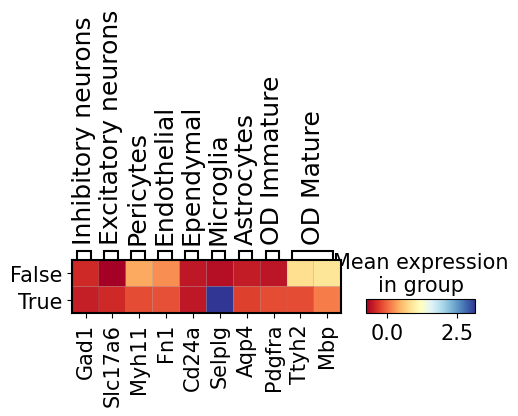

True     1464
False       8
Name: conf_binaries, dtype: int64
Astrocyte


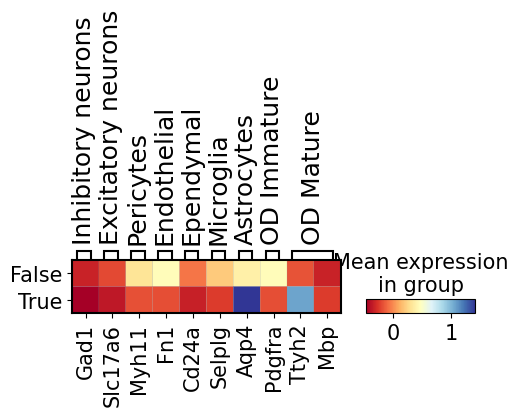

True     8349
False      44
Name: conf_binaries, dtype: int64
Endothelial


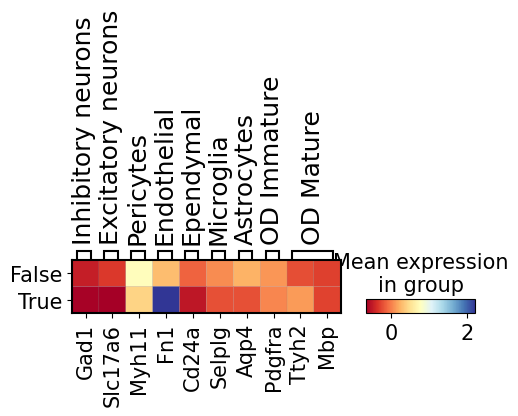

True     5691
False      58
Name: conf_binaries, dtype: int64
Pericytes


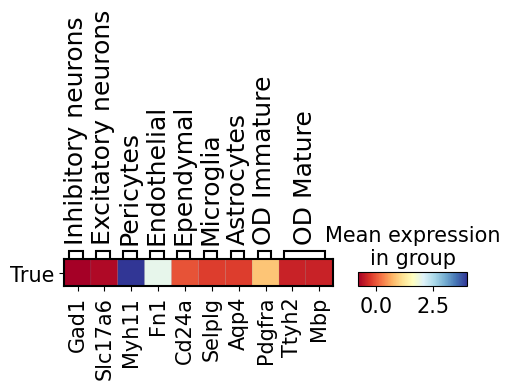

True    638
Name: conf_binaries, dtype: int64
Ependymal


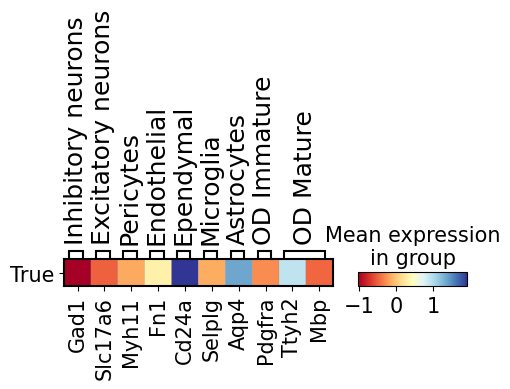

True    1961
Name: conf_binaries, dtype: int64


In [21]:
celltype_list = adata.obs['CellType'].unique()
for celltype in celltype_list:
    print(celltype)
    adata_tmp= bdata[bdata.obs['CellType'].isin([celltype])]
    ax = sc.pl.matrixplot(adata_tmp, marker_genes_dict, groupby='conf_binaries', cmap='RdYlBu')
    print(adata_tmp.obs['conf_binaries'].value_counts())

In [22]:
bdata= adata[adata.obs['conf_binaries'].isin([True])]
cdata= bdata.copy()
sc.pp.scale(cdata)

In [23]:
hdata = models.predict_true_labels(adata, label='CellType', device=device, epoch_num=20)

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.202
[1,    22] loss: 2.166
[1,    32] loss: 2.115
[1,    42] loss: 2.081
[1,    52] loss: 2.029
[1,    62] loss: 1.969
[1,    72] loss: 1.911
[1,    82] loss: 1.870
[1,    92] loss: 1.786
[1,   102] loss: 1.714
[1,   112] loss: 1.634
[1,   122] loss: 1.559
[1,   132] loss: 1.454
[1,   142] loss: 1.376
[1,   152] loss: 1.272
[1,   162] loss: 1.178
[1,   172] loss: 1.088
[1,   182] loss: 1.005
[1,   192] loss: 0.928
[1,   202] loss: 0.859
[1,   212] loss: 0.789
[1,   222] loss: 0.745
[1,   232] loss: 0.707
[1,   242] loss: 0.657
[2,     2] loss: 0.129
[2,    12] loss: 0.582
[2,    22] loss: 0.566
[2,    32] loss: 0.525
[2,    42] loss: 0.519
[2,    52] loss: 0.478
[2,    62] loss: 0.472
[2,    72] loss: 0.447
[2,    82] loss: 0.444
[2,    92] loss: 0.420
[2,   102] loss: 0.402
[2,   112] loss: 0.384
[2,   122] loss: 0.381
[2,   132] loss: 0.378
[2,   142] loss: 0.363
[2,   152] loss: 0.348
[2,   162] loss: 0.350
[2,   172] loss: 0.341
[2,   182] 

[15,   102] loss: 0.122
[15,   112] loss: 0.123
[15,   122] loss: 0.129
[15,   132] loss: 0.136
[15,   142] loss: 0.148
[15,   152] loss: 0.119
[15,   162] loss: 0.131
[15,   172] loss: 0.124
[15,   182] loss: 0.131
[15,   192] loss: 0.151
[15,   202] loss: 0.128
[15,   212] loss: 0.159
[15,   222] loss: 0.138
[15,   232] loss: 0.139
[15,   242] loss: 0.133
[16,     2] loss: 0.026
[16,    12] loss: 0.121
[16,    22] loss: 0.135
[16,    32] loss: 0.120
[16,    42] loss: 0.134
[16,    52] loss: 0.139
[16,    62] loss: 0.110
[16,    72] loss: 0.130
[16,    82] loss: 0.125
[16,    92] loss: 0.127
[16,   102] loss: 0.140
[16,   112] loss: 0.133
[16,   122] loss: 0.146
[16,   132] loss: 0.135
[16,   142] loss: 0.135
[16,   152] loss: 0.106
[16,   162] loss: 0.135
[16,   172] loss: 0.121
[16,   182] loss: 0.141
[16,   192] loss: 0.150
[16,   202] loss: 0.113
[16,   212] loss: 0.125
[16,   222] loss: 0.129
[16,   232] loss: 0.119
[16,   242] loss: 0.128
[17,     2] loss: 0.019
[17,    12] loss

In [24]:
hdata

AnnData object with n_obs × n_vars = 64373 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'conf_binaries', 'CorrectedCellType'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata_false_annotation= adata[adata.obs['conf_binaries'].isin([False])]

In [26]:
adata_true_annotation= adata[adata.obs['conf_binaries'].isin([True])]

In [27]:
hdata.obs['changed_anno'] = (hdata.obs['CellType']==hdata.obs['CorrectedCellType'])

In [28]:
adata_did_not_changed= hdata[hdata.obs['changed_anno'].isin([True])]
adata_did_not_changed = adata_did_not_changed[adata_did_not_changed.obs['conf_binaries'].isin([False])]
adata_did_not_changed

View of AnnData object with n_obs × n_vars = 0 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'conf_binaries', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
adata_annotation_changed= hdata[hdata.obs['changed_anno'].isin([False])]

In [30]:
adata_annotation_changed

View of AnnData object with n_obs × n_vars = 906 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'conf_binaries', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

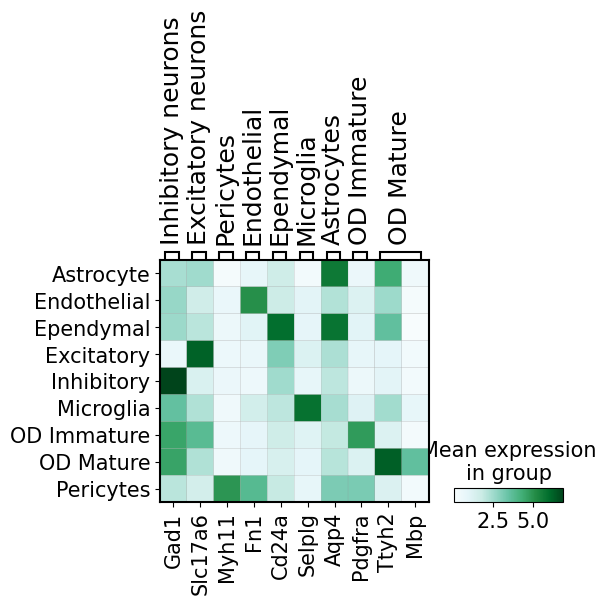

In [31]:
adata_annotation_changed_scaled = adata_annotation_changed.copy()
ax = sc.pl.matrixplot(adata_annotation_changed_scaled, marker_genes_dict, groupby='CorrectedCellType', cmap='BuGn')


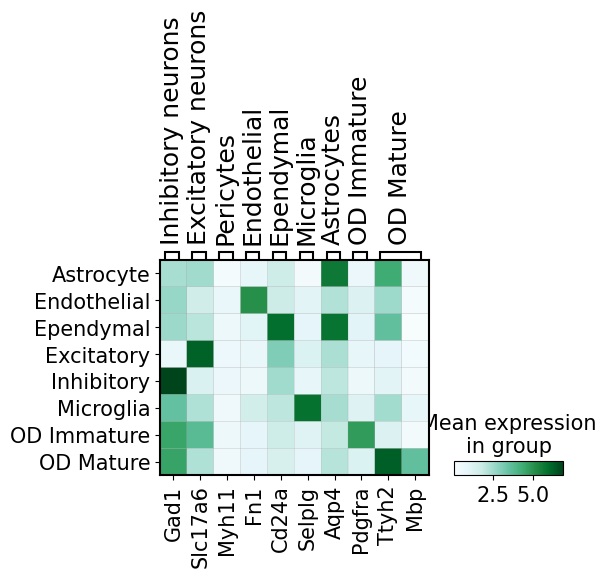

In [32]:
adata_annotation_changed_no_per= adata_annotation_changed[adata_annotation_changed.obs['CorrectedCellType'].isin(['Astrocyte',
                                            'Endothelial', 'Ependymal',
                                            'Excitatory',
                                            'Inhibitory', 'Microglia', 'OD Immature',
                                                                                                         'OD Mature'])]
ax = sc.pl.matrixplot(adata_annotation_changed_no_per, marker_genes_dict, groupby='CorrectedCellType', cmap='BuGn')


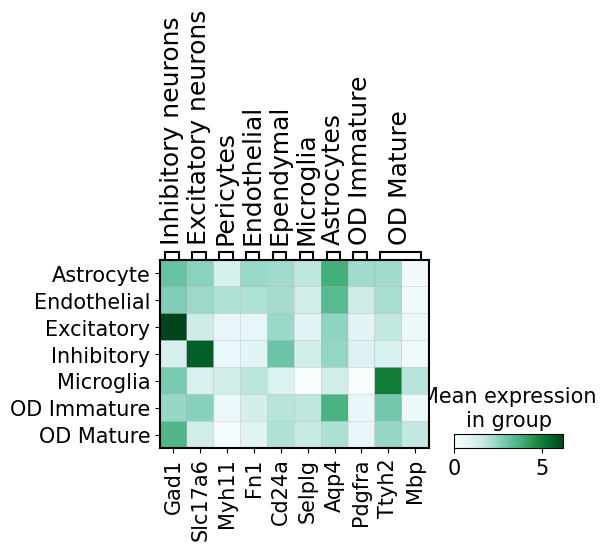

In [33]:
adata_false_annotated= hdata[hdata.obs['conf_binaries'].isin([False])]
ax = sc.pl.matrixplot(adata_false_annotated, marker_genes_dict, groupby='CellType', cmap='BuGn')


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [A

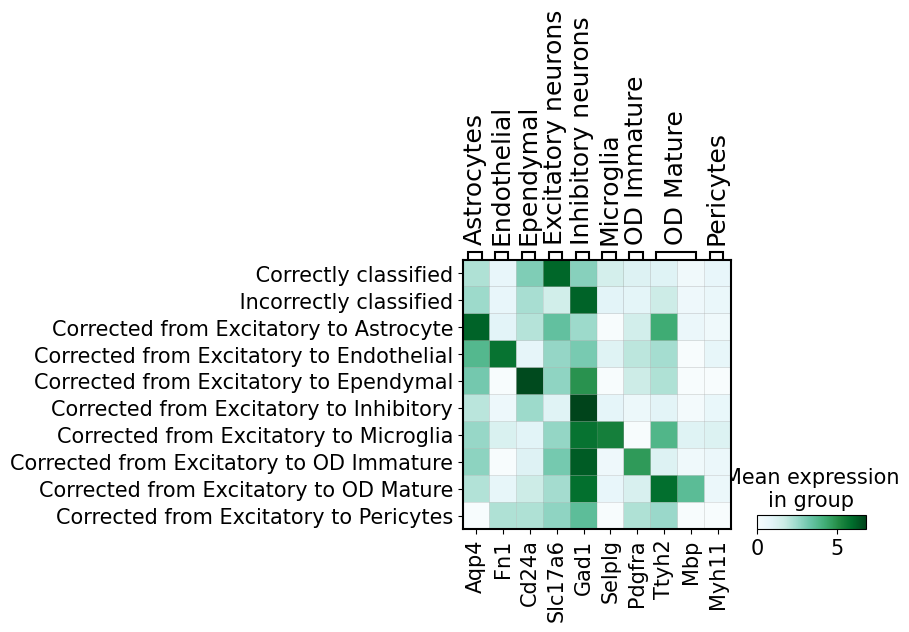

In [34]:
tmp_tdata2 = hdata[hdata.obs['CellType'].isin(['Excitatory'])]
False_or_pos = []
for i in range(tmp_tdata2.n_obs):
    if tmp_tdata2.obs['conf_binaries'][i]:
        False_or_pos.append(' Correctly classified')
    else:
        False_or_pos.append(' Incorrectly classified')

tmp_tdata2.obs['Celltype_to_corrected'] = False_or_pos


Celltype_to_corrected =[]
for i in range(adata_false_annotated.n_obs):
    string = str(adata_false_annotated.obs['CellType'][i]) + "_" + str(adata_false_annotated.obs['CorrectedCellType'][i])
    Celltype_to_corrected.append(string)
adata_false_annotated.obs['Celltype_to_corrected'] = Celltype_to_corrected

tmp_tdata = adata_false_annotated[adata_false_annotated.obs['CellType'].isin(['Excitatory'])]
Celltype_to_corrected =[]
for i in range(tmp_tdata.n_obs):
        if tmp_tdata.obs['conf_binaries'][i]==False:        
            string = "Corrected from " + str(tmp_tdata.obs['CellType'][i]) + " to " + str(tmp_tdata.obs['CorrectedCellType'][i])
        Celltype_to_corrected.append(string)

tmp_tdata.obs['Celltype_to_corrected'] = Celltype_to_corrected

marker_genes_dict = {
                     'Astrocytes': ['Aqp4'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Microglia':['Selplg'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp'],
                     'Pericytes':['Myh11']}

#sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='RdYlBu')

tmp_tdata3 = tmp_tdata2.concatenate(tmp_tdata)




ax = sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='BuGn')


/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/ipykernel_launcher.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


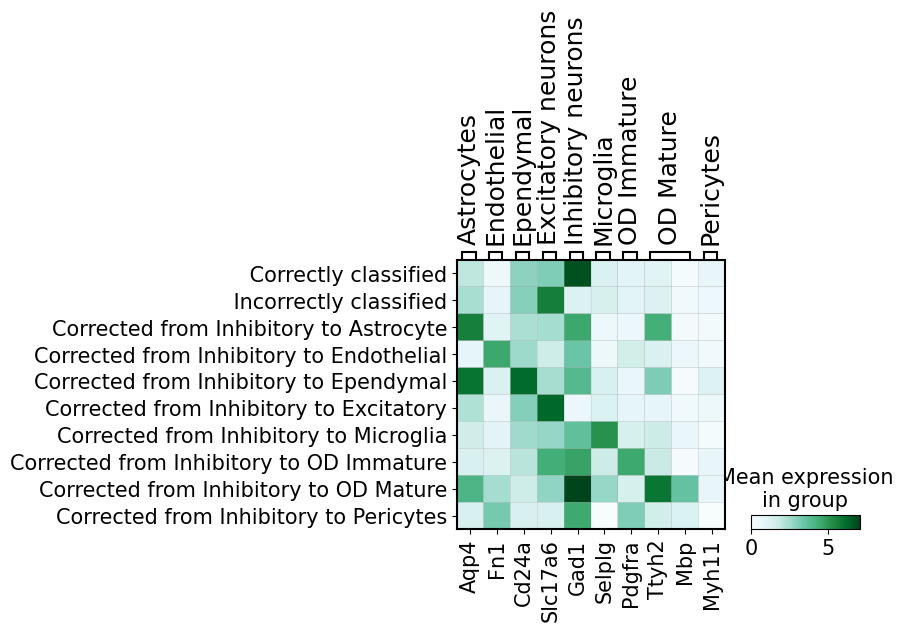

In [35]:
tmp_tdata2 = hdata[hdata.obs['CellType'].isin(['Inhibitory'])]
False_or_pos = []
for i in range(tmp_tdata2.n_obs):
    if tmp_tdata2.obs['conf_binaries'][i]:
        False_or_pos.append(' Correctly classified')
    else:
        False_or_pos.append(' Incorrectly classified')

tmp_tdata2.obs['Celltype_to_corrected'] = False_or_pos


Celltype_to_corrected =[]
for i in range(adata_false_annotated.n_obs):
    string = str(adata_false_annotated.obs['CellType'][i]) + "_" + str(adata_false_annotated.obs['CorrectedCellType'][i])
    Celltype_to_corrected.append(string)
adata_false_annotated.obs['Celltype_to_corrected'] = Celltype_to_corrected

tmp_tdata = adata_false_annotated[adata_false_annotated.obs['CellType'].isin(['Inhibitory'])]
Celltype_to_corrected =[]
for i in range(tmp_tdata.n_obs):
        if tmp_tdata.obs['conf_binaries'][i]==False:        
            string = "Corrected from " + str(tmp_tdata.obs['CellType'][i]) + " to " + str(tmp_tdata.obs['CorrectedCellType'][i])
        Celltype_to_corrected.append(string)

tmp_tdata.obs['Celltype_to_corrected'] = Celltype_to_corrected

marker_genes_dict = {
                     'Astrocytes': ['Aqp4'],
                     'Endothelial':['Fn1'],
                     'Ependymal':['Cd24a'],
                     'Excitatory neurons': ['Slc17a6'],
                     'Inhibitory neurons':['Gad1'],#, 'Gad2', 'Slc32a1'],
                     'Microglia':['Selplg'],
                     'OD Immature': ['Pdgfra'],
                     'OD Mature':['Ttyh2','Mbp'],
                     'Pericytes':['Myh11']}


tmp_tdata3 = tmp_tdata2.concatenate(tmp_tdata)






ax = sc.pl.matrixplot(tmp_tdata3, marker_genes_dict, groupby='Celltype_to_corrected', cmap='BuGn')


In [36]:
adata_annotation_changed

View of AnnData object with n_obs × n_vars = 906 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts', 'CellType', 'var', 'conf', 'conf_binaries', 'CorrectedCellType', 'changed_anno'
    uns: 'Cell_class_colors', 'log1p', 'pca', 'neighbors', 'umap', 'CellType_colors'
    obsm: 'spatial', 'spatial3d', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
def print_all_mean_expressions(adata,genes_list,label):
    annotations_list = adata.obs[label].unique()
    for gene in genes_list:
        for annotation in annotations_list:
            print("Mean expression of " + gene +" in " + annotation)
            print(get_mean_expression(adata, gene, label,annotation))
def get_mean_expression(adata, gene, label,annotation):
    adata_tmp = (adata[adata.obs[label].isin([annotation])])
    mean_expression = float(np.mean(adata_tmp[:, gene].X.toarray()))
    return mean_expression


In [38]:
print_all_mean_expressions(adata_annotation_changed,marker_genes_list,'CorrectedCellType')

Mean expression of Gad1 in Excitatory
0.6625111699104309
Mean expression of Gad1 in Inhibitory
6.85623836517334
Mean expression of Gad1 in Astrocyte
2.3437752723693848
Mean expression of Gad1 in Endothelial
2.6385304927825928
Mean expression of Gad1 in Pericytes
2.043269395828247
Mean expression of Gad1 in Microglia
3.5066277980804443
Mean expression of Gad1 in OD Immature
4.537909984588623
Mean expression of Gad1 in Ependymal
2.569777011871338
Mean expression of Gad1 in OD Mature
4.558234214782715
Mean expression of Slc17a6 in Excitatory
6.2318220138549805
Mean expression of Slc17a6 in Inhibitory
1.319706916809082
Mean expression of Slc17a6 in Astrocyte
2.474745273590088
Mean expression of Slc17a6 in Endothelial
1.6344043016433716
Mean expression of Slc17a6 in Pericytes
1.5362135171890259
Mean expression of Slc17a6 in Microglia
2.2190582752227783
Mean expression of Slc17a6 in OD Immature
3.7556121349334717
Mean expression of Slc17a6 in Ependymal
2.0449304580688477
Mean expression of S

In [39]:
print_all_mean_expressions(adata_false_annotation,marker_genes_list,'CellType')

Mean expression of Gad1 in Inhibitory
1.2149240970611572
Mean expression of Gad1 in Excitatory
6.180581569671631
Mean expression of Gad1 in Astrocyte
3.085357427597046
Mean expression of Gad1 in Endothelial
2.7039644718170166
Mean expression of Gad1 in OD Mature
3.536952257156372
Mean expression of Gad1 in OD Immature
2.345212459564209
Mean expression of Gad1 in Microglia
2.808074474334717
Mean expression of Slc17a6 in Inhibitory
5.679109573364258
Mean expression of Slc17a6 in Excitatory
1.5374791622161865
Mean expression of Slc17a6 in Astrocyte
2.5551087856292725
Mean expression of Slc17a6 in Endothelial
2.2577688694000244
Mean expression of Slc17a6 in OD Mature
1.437195062637329
Mean expression of Slc17a6 in OD Immature
2.573441505432129
Mean expression of Slc17a6 in Microglia
1.1654562950134277
Mean expression of Myh11 in Inhibitory
0.5427016615867615
Mean expression of Myh11 in Excitatory
0.6339704394340515
Mean expression of Myh11 in Astrocyte
1.2508383989334106
Mean expression of

In [40]:
print_all_mean_expressions(adata_true_annotation,marker_genes_list,'CellType')

Mean expression of Gad1 in OD Mature
1.504415512084961
Mean expression of Gad1 in OD Immature
4.548402309417725
Mean expression of Gad1 in Inhibitory
6.82316780090332
Mean expression of Gad1 in Excitatory
2.8707408905029297
Mean expression of Gad1 in Microglia
2.5812089443206787
Mean expression of Gad1 in Astrocyte
2.6806082725524902
Mean expression of Gad1 in Endothelial
2.181870460510254
Mean expression of Gad1 in Pericytes
1.7570804357528687
Mean expression of Gad1 in Ependymal
0.9773175120353699
Mean expression of Slc17a6 in OD Mature
1.0711820125579834
Mean expression of Slc17a6 in OD Immature
2.9336061477661133
Mean expression of Slc17a6 in Inhibitory
3.1171295642852783
Mean expression of Slc17a6 in Excitatory
6.095922946929932
Mean expression of Slc17a6 in Microglia
2.0032601356506348
Mean expression of Slc17a6 in Astrocyte
2.1275463104248047
Mean expression of Slc17a6 in Endothelial
1.4262787103652954
Mean expression of Slc17a6 in Pericytes
1.3610037565231323
Mean expression of